In [135]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# LSTM Model Definition with Dropout to reduce overfitting
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size

        # Define LSTM layer with Dropout
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=dropout_prob)

        # Define a fully connected layer for output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initializing hidden state and cell state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initial hidden state
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initial cell state

        # LSTM forward pass
        out, (hn, cn) = self.lstm(x, (h0, c0))

        # Pass the output of the last timestep to the fully connected layer
        out = self.fc(out[:, -1, :])  # Using the output from the last time step for prediction
        return out


In [102]:
# Load .vec file (input patterns) and .test file (fault-free responses)
def load_vec_file(file_path):
    with open(file_path, 'r') as file:
        data = file.readlines()

    # Clean and convert binary data into integers, skipping non-binary lines like "END"
    return [
        [int(bit) for bit in line.strip() if bit == '0' or bit == '1']
        for line in data if line.strip() and 'END' not in line  # Skip lines containing "END"
    ]

def load_test_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    input_data = []
    output_data = []

    for line in lines:
        line = line.strip()

        # Skip lines that don’t start with a number followed by a colon
        if not line or not line.split()[0].endswith(":"):
            continue

        parts = line.split()
        if len(parts) < 3:
            continue  # avoid malformed lines

        pattern_bits = ''.join([bit for bit in parts[1] if bit in '01'])
        response_bits = ''.join([bit for bit in parts[2] if bit in '01'])

        input_data.append([int(bit) for bit in pattern_bits])
        output_data.append([int(bit) for bit in response_bits])

    return input_data, output_data

# Load the input and output data
input_data = load_vec_file('/content/drive/My Drive/eec286/circuits/c499.vec')
output_data, fault_responses = load_test_file('/content/drive/My Drive/eec286/circuits/c499.test')

# Convert to numpy arrays for easier processing
input_data = np.array(input_data)
output_data = np.array(output_data)

# Normalize input data using StandardScaler
scaler = StandardScaler()
input_data = scaler.fit_transform(input_data)

# Reshape input data for LSTM: (samples, timesteps, features)
# Here we treat each pattern as a single timestep with multiple features
input_data = input_data.reshape(input_data.shape[0], 1, input_data.shape[1])


Unique lengths in output_data: {41}


In [85]:
test_path = '/content/drive/My Drive/eec286/circuits/c499.test'
vec_path = '/content/drive/My Drive/eec286/circuits/c499.vec'

In [118]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.2, random_state=42)

# Convert the data into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [119]:
from torch.utils.data import TensorDataset, DataLoader

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [121]:
print(X_train_tensor.shape)
print(X_test_tensor.shape)

torch.Size([44, 1, 41])
torch.Size([12, 1, 41])


In [122]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [123]:
input_size = X_train_tensor.shape[2]  # Since LSTM input is (batch, seq_len, input_size)
hidden_size = 64
output_size = y_train_tensor.shape[1]

model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.BCEWithLogitsLoss()  # More stable than using Sigmoid + BCELoss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [131]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_train_accuracy = 0.0
    total_train_samples = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_batch)

        # Calculate loss
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Convert outputs to binary predictions (0 or 1)
        predicted_bits = (outputs > 0.5).int()

        # Calculate bit-level accuracy for this batch
        correct_bits = (predicted_bits == y_batch.int()).float()
        batch_accuracy = correct_bits.mean()

        # Accumulate accuracy
        total_train_accuracy += batch_accuracy.item()
        total_train_samples += 1

    avg_train_loss = total_loss / len(train_loader)
    avg_train_accuracy = total_train_accuracy / total_train_samples
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Bit-Level Accuracy: {avg_train_accuracy:.4f}")


Epoch 1/50, Loss: 0.3501, Bit-Level Accuracy: 0.9028
Epoch 2/50, Loss: 0.3241, Bit-Level Accuracy: 0.9174
Epoch 3/50, Loss: 0.3334, Bit-Level Accuracy: 0.9041
Epoch 4/50, Loss: 0.3249, Bit-Level Accuracy: 0.9066
Epoch 5/50, Loss: 0.3124, Bit-Level Accuracy: 0.9054
Epoch 6/50, Loss: 0.3059, Bit-Level Accuracy: 0.9123
Epoch 7/50, Loss: 0.3021, Bit-Level Accuracy: 0.9104
Epoch 8/50, Loss: 0.2951, Bit-Level Accuracy: 0.9085
Epoch 9/50, Loss: 0.2831, Bit-Level Accuracy: 0.9123
Epoch 10/50, Loss: 0.2913, Bit-Level Accuracy: 0.9092
Epoch 11/50, Loss: 0.2942, Bit-Level Accuracy: 0.8990
Epoch 12/50, Loss: 0.2841, Bit-Level Accuracy: 0.9079
Epoch 13/50, Loss: 0.2734, Bit-Level Accuracy: 0.9092
Epoch 14/50, Loss: 0.2728, Bit-Level Accuracy: 0.9073
Epoch 15/50, Loss: 0.2627, Bit-Level Accuracy: 0.9143
Epoch 16/50, Loss: 0.2572, Bit-Level Accuracy: 0.9117
Epoch 17/50, Loss: 0.2593, Bit-Level Accuracy: 0.9085
Epoch 18/50, Loss: 0.2642, Bit-Level Accuracy: 0.8984
Epoch 19/50, Loss: 0.2434, Bit-Level 

In [133]:
model.eval()
all_preds = []
all_targets = []

# Initialize variables for accuracy calculation
correct_preds = 0
total_preds = 0

with torch.no_grad():
    total_loss = 0.0
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        total_loss += loss.item()

        # Convert the outputs into binary predictions (0 or 1)
        predicted_bits = (outputs > 0.5).int()

        # Compare predictions with the true values to count correct predictions
        correct_preds += (predicted_bits == y_batch.int()).sum().item()
        total_preds += y_batch.numel()

        # Save predictions and targets for future evaluation or plotting
        all_preds.append(outputs)
        all_targets.append(y_batch)

    # Calculate average loss
    avg_loss = total_loss / len(test_loader)

    # Calculate accuracy (number of correct predictions / total predictions)
    accuracy = correct_preds / total_preds

    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")


Test Loss: 0.3200, Test Accuracy: 0.9126


In [134]:
predicted = torch.sigmoid(outputs) > 0.5


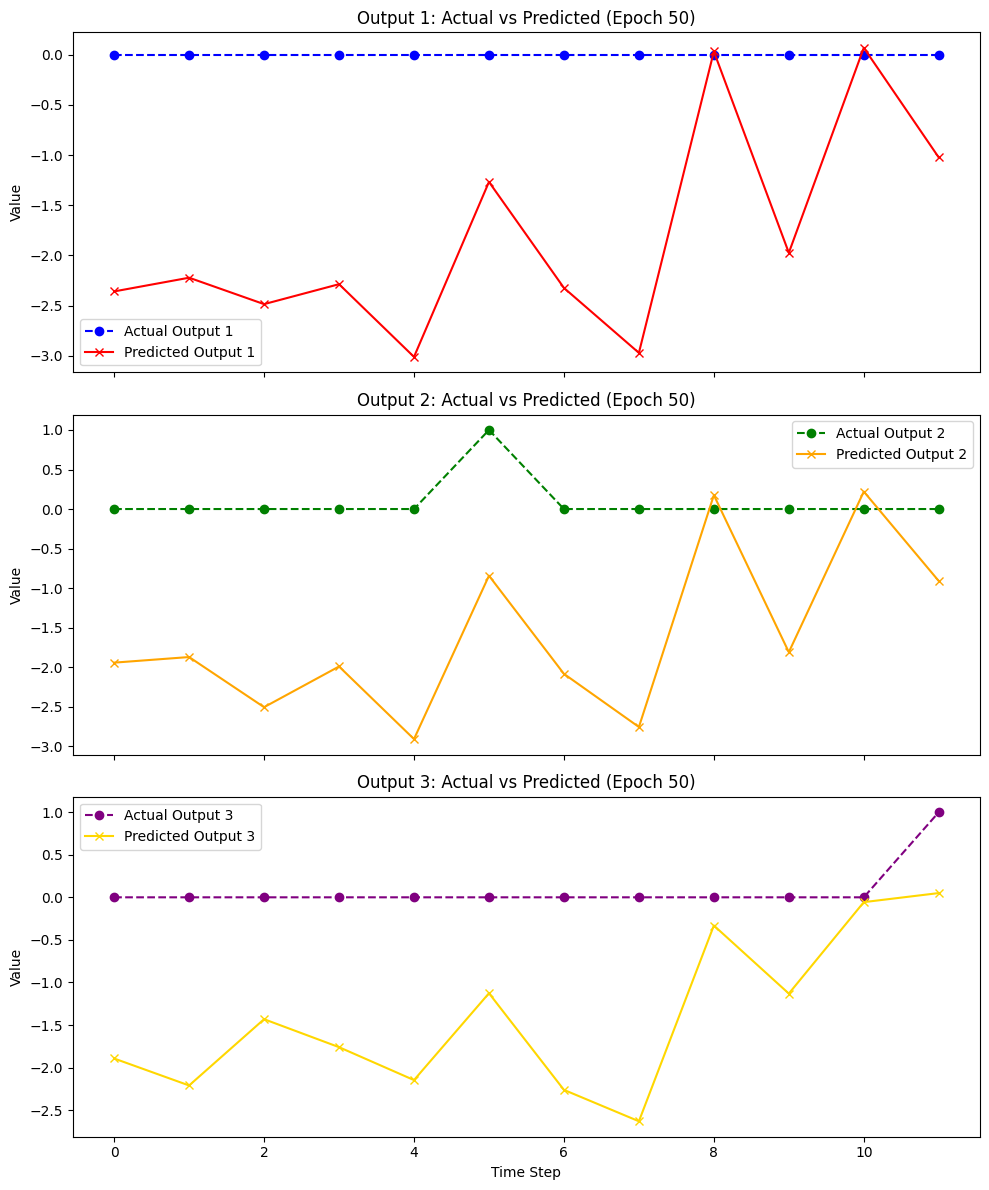

In [137]:
# After you have the epoch number, e.g. from a training loop

# Combine all predictions and targets into single tensors
predicted_output = torch.cat(all_preds, dim=0).cpu().numpy()
target_output = torch.cat(all_targets, dim=0).cpu().numpy()

# Plotting each output in its own subplot
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

output_labels = ['Output 1', 'Output 2', 'Output 3']
colors = [('blue', 'red'), ('green', 'orange'), ('purple', 'gold')]

for i in range(3):
    axs[i].plot(target_output[:, i], label=f'Actual {output_labels[i]}', color=colors[i][0], linestyle='--', marker='o')
    axs[i].plot(predicted_output[:, i], label=f'Predicted {output_labels[i]}', color=colors[i][1], linestyle='-', marker='x')
    axs[i].set_ylabel('Value')
    axs[i].legend()
    axs[i].set_title(f'{output_labels[i]}: Actual vs Predicted (Epoch {epoch+1})')  # Add Epoch number to title

axs[-1].set_xlabel('Time Step')
plt.tight_layout()
plt.show()
